--- Starting Main Calculation ---
Ts=280.0K …Ts=281.0K …Ts=282.0K …Ts=283.0K …Ts=284.0K …Ts=285.0K …Ts=286.0K …Ts=287.0K …Ts=288.0K …Ts=289.0K …Ts=290.0K …Ts=291.0K …Ts=292.0K …Ts=293.0K …Ts=294.0K …Ts=295.0K …Ts=296.0K …Ts=297.0K …Ts=298.0K …Ts=299.0K …Ts=300.0K …Ts=301.0K …Ts=302.0K …Ts=303.0K …Ts=304.0K …Ts=305.0K …Ts=306.0K …Ts=307.0K …Ts=308.0K …Ts=309.0K …Ts=310.0K …Ts=311.0K …Ts=312.0K …Ts=313.0K …Ts=314.0K …Ts=315.0K …Ts=316.0K …Ts=317.0K …Ts=318.0K …Ts=319.0K …Ts=320.0K …Done in 2.6s


/var/folders/vt/gqrlflhj10b1g04_6pcq_q3r0000gn/T/ipykernel_9462/1935702621.py:266: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


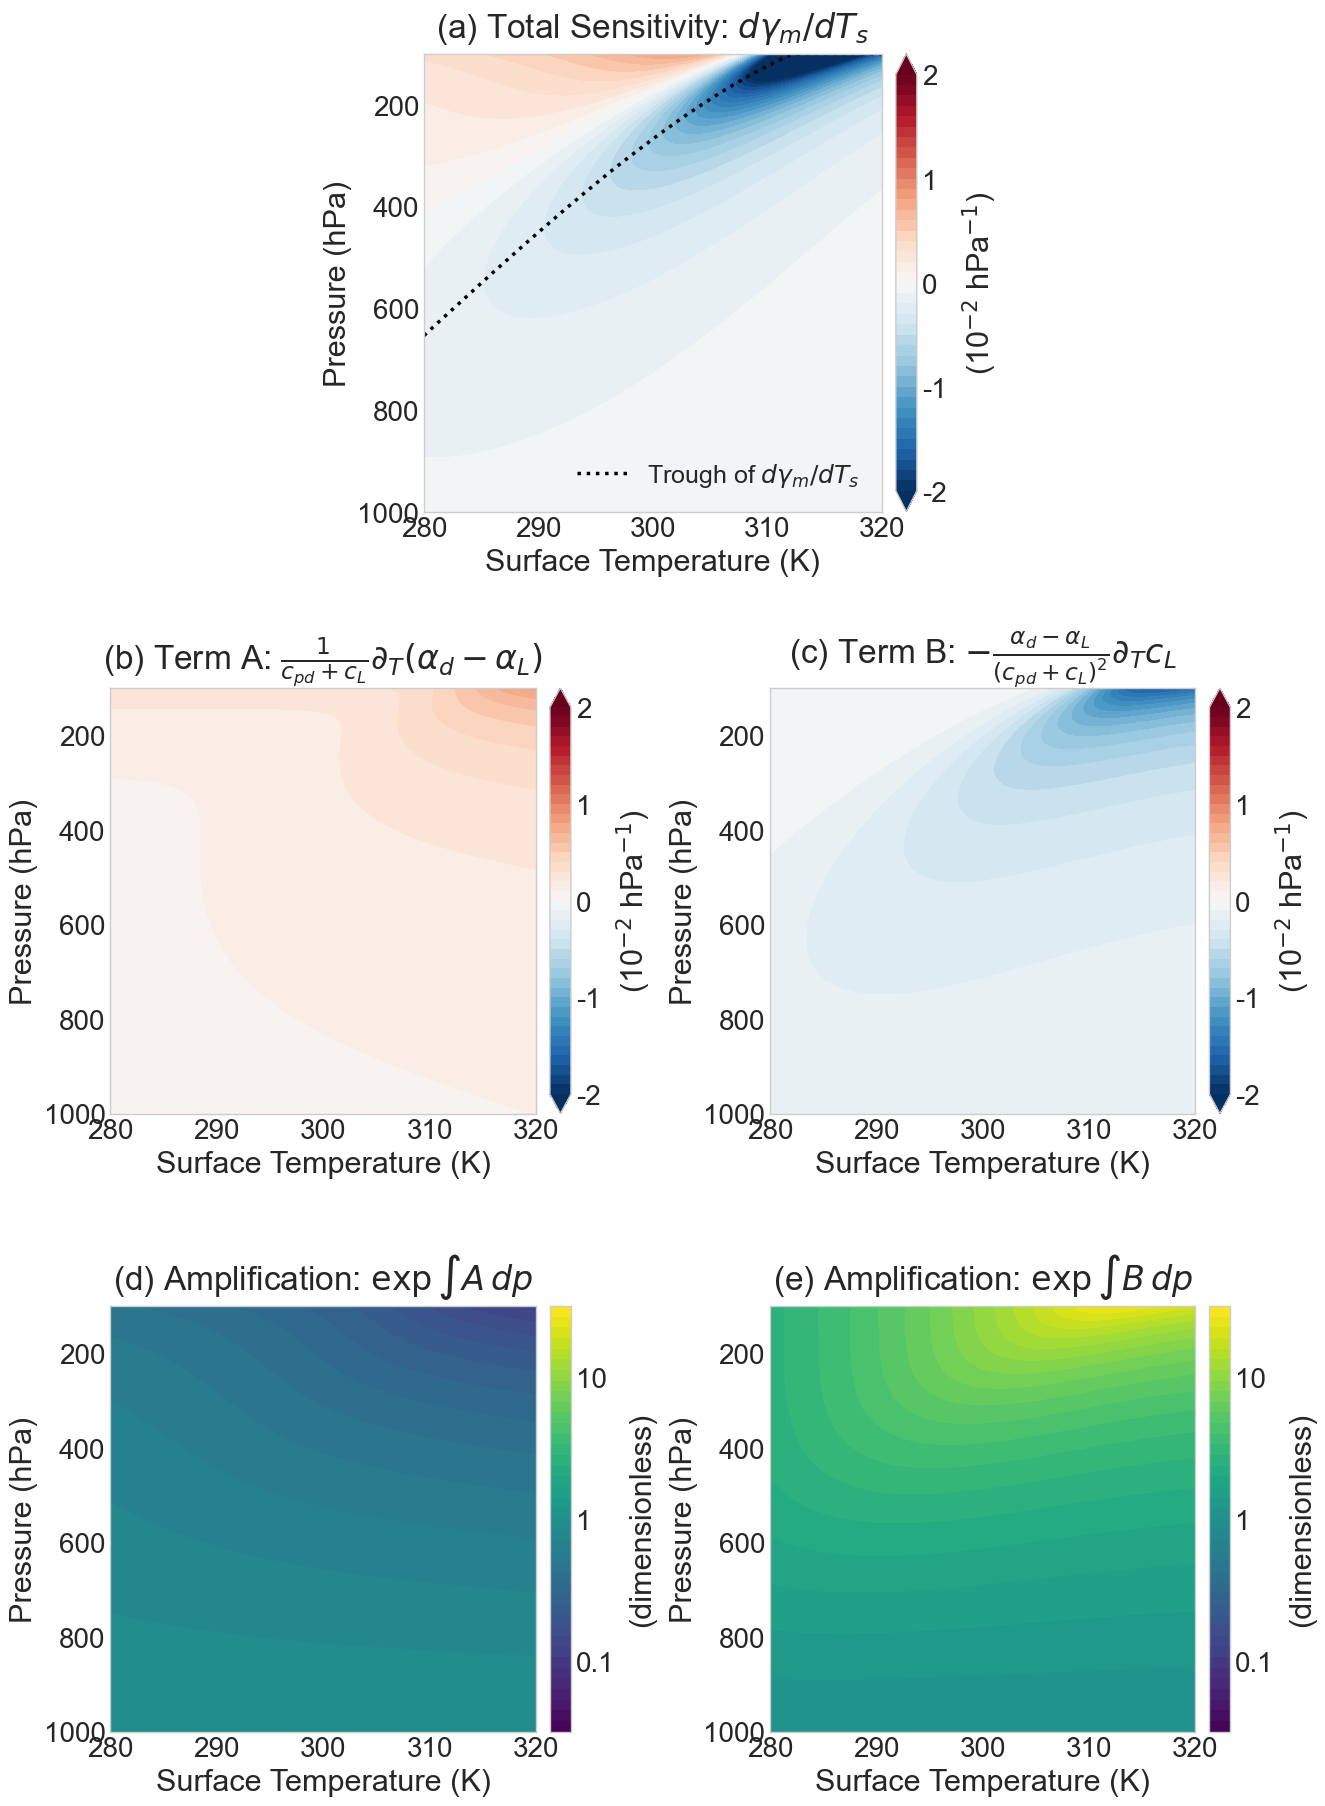

In [6]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE 2 (5-Panel: A/B split + their amplifications)
#
# Panels:
#  (a) Total Sensitivity: d(gamma_m)/dTs
#  (b) Term A = (1/(cpd + cL)) * d(αd - αL)/dT
#  (c) Term B = - (αd - αL)/(cpd + cL)^2 * d(cL)/dT
#  (d) exp( ∫ A dp )
#  (e) exp( ∫ B dp )
#
# Layout:
#    a
#   b   c
#   d   e
#
# Notes:
#  * Local terms (a,b,c) share the SAME diverging scale.
#  * Amplification terms (d,e) use a logarithmic colormap with ticks at 0.1, 1, 10.
#  * All panels are drawn with square axes.
#  * Trough of total sensitivity is overlaid on (a).
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.integrate import cumulative_trapezoid
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd  = 287.05
Rv  = 461.5
epsilon = Rd / Rv
Lv = 2.501e6

# --- Thermodynamic Functions ---
def saturation_vapor_pressure(T):
    T_c = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_c)/(T_c + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    denom = p - (1.0 - epsilon) * es
    qs = np.divide(epsilon * es, denom, out=np.full_like(p,1e-9), where=denom>0)
    return np.maximum(qs,1e-9)

def dqs_dT(p, T, dT=0.01):
    return (saturation_specific_humidity(p, T + dT)
          - saturation_specific_humidity(p, T - dT)) / (2*dT)

def dqs_dp(p, T, dp=10.0):
    return (saturation_specific_humidity(p + dp, T)
          - saturation_specific_humidity(p - dp, T)) / (2*dp)

def d2qs_dT2(p, T, dT=0.01):
    qs_p = saturation_specific_humidity(p, T + dT)
    qs_0 = saturation_specific_humidity(p, T)
    qs_m = saturation_specific_humidity(p, T - dT)
    return (qs_p - 2*qs_0 + qs_m) / (dT**2)

def d2qs_dTdp(p, T, dT=0.01, dp=10.0):
    dT_plus  = dqs_dT(p + dp, T, dT)
    dT_minus = dqs_dT(p - dp, T, dT)
    return (dT_plus - dT_minus) / (2*dp)

def virtual_temperature(T, p):
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1 + (1/epsilon - 1)*qs)
    return np.maximum(Tv,10.0)

def calculate_mse(T, p, z):
    qs = saturation_specific_humidity(p, T)
    return cpd * T + g * z + Lv * qs

def calculate_profile_with_rootfinder(T_surf, p_surf, p_grid):
    n = len(p_grid)
    T_prof = np.full(n, np.nan)
    z_prof = np.full(n, np.nan)
    T_prof[0], z_prof[0] = T_surf, 0.0
    mse0 = calculate_mse(T_surf, p_grid[0], 0.0)

    for i in range(n-1):
        T_cur, p_cur, z_cur = T_prof[i], p_grid[i], z_prof[i]
        p_next = p_grid[i+1]
        if np.isnan(T_cur) or p_cur <= 0:
            break

        Tv = virtual_temperature(T_cur, p_cur)
        dz = - (Rd * Tv / p_cur) / g * (p_next - p_cur)
        z_next = z_cur + dz

        def resid(Tg):
            return calculate_mse(Tg, p_next, z_next) - mse0

        try:
            br = [150.0, T_cur + 5.0]
            if resid(br[0]) * resid(br[1]) > 0:
                break
            sol = root_scalar(resid, bracket=br, method='brentq', xtol=1e-3)
            if sol.converged:
                T_prof[i+1], z_prof[i+1] = sol.root, z_next
            else:
                break
        except:
            break

    return T_prof

print("--- Starting Main Calculation ---")
t0 = time.time()

# --- Grid setup ---
T_surf_vals = np.arange(280, 320.1, 1.0)
p_s, p_top, dp = 100000.0, 10000.0, -50.0
p_grid = np.arange(p_s, p_top + dp, dp)

n_p, n_t = len(p_grid), len(T_surf_vals)
tot_grid = np.full((n_p, n_t), np.nan)
A_grid   = np.full((n_p, n_t), np.nan)
B_grid   = np.full((n_p, n_t), np.nan)
ampA     = np.full((n_p, n_t), np.nan)
ampB     = np.full((n_p, n_t), np.nan)

for j, Ts in enumerate(T_surf_vals):
    print(f"Ts={Ts:.1f}K …", end='')
    Tprof = calculate_profile_with_rootfinder(Ts, p_s, p_grid)
    if np.isnan(Tprof[-1]):
        print(" fail"); continue
    # thermodynamics
    alpha_d = Rd * Tprof / p_grid
    cL      = Lv * dqs_dT(p_grid, Tprof)
    alpha_L = Lv * dqs_dp(p_grid, Tprof)
    dal_dT  = Lv * d2qs_dTdp(p_grid, Tprof)
    dcL_dT  = Lv * d2qs_dT2(p_grid, Tprof)

    N  = alpha_d - alpha_L
    D  = cpd + cL
    dN = (Rd/p_grid) - dal_dT
    dD = dcL_dT

    A_loc = (1.0/D)*dN
    B_loc = - (N/(D**2))*dD

    intA = cumulative_trapezoid(A_loc, x=p_grid, initial=0.0)
    intB = cumulative_trapezoid(B_loc, x=p_grid, initial=0.0)

    ampA[:, j]   = np.exp(intA)
    ampB[:, j]   = np.exp(intB)
    tot_grid[:, j] = (A_loc + B_loc) * np.exp(intA + intB)

    A_grid[:, j] = A_loc
    B_grid[:, j] = B_loc

print(f"Done in {time.time() - t0:.1f}s")

# find trough
with np.errstate(invalid='ignore'):
    trough_idx = np.nanargmin(tot_grid, axis=0)
p_trough = p_grid[trough_idx] / 100.0
valid    = np.isfinite(p_trough)

# --- Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size':22,
    'axes.titlesize':24,
    'axes.labelsize':22,
    'xtick.labelsize':20,
    'ytick.labelsize':20,
    'legend.fontsize':18
})

p_hpa = p_grid / 100.0
Tmat, Pmat = np.meshgrid(T_surf_vals, p_hpa)

# local scales - changed to 10^-2 units for better spacing
scale     = 1e4  # Changed from 1e6 to 1e4 (10^-4 to 10^-2)
limits    = 2    # Changed from 200 to 2
levels_loc= np.arange(-limits, limits+0.1, 0.1)  # Changed step from 10 to 0.1
cmap_loc  = plt.get_cmap('RdBu_r')

# amp scales (log)
levels_log = np.logspace(-1.5, 1.5, 41)
cmap_amp   = plt.get_cmap('viridis')

# figure & gridspec
fig = plt.figure(figsize=(14,22))
gs  = GridSpec(3, 2, height_ratios=[1.0,1.0,1.0],
               hspace=0.35, wspace=0.55)

# Create subplots
axs = {
    'a': fig.add_subplot(gs[0,:]),
    'b': fig.add_subplot(gs[1,0]),
    'c': fig.add_subplot(gs[1,1]),
    'd': fig.add_subplot(gs[2,0]),
    'e': fig.add_subplot(gs[2,1]),
}

# Set box aspect to ensure square axes
for ax in axs.values():
    ax.set_box_aspect(1)

def draw(ax, Z, levels, cmap, title, label, trough=False, log=False):
    if log:
        cf = ax.contourf(
            Tmat, Pmat, Z, levels=levels,
            norm=LogNorm(vmin=levels[0], vmax=levels[-1]),
            cmap=cmap
        )
    else:
        cf = ax.contourf(
            Tmat, Pmat, Z, levels=levels,
            cmap=cmap, extend='both'
        )
    
    # Set title and labels
    ax.set_title(title, pad=12)
    ax.set_ylabel('Pressure (hPa)')
    ax.invert_yaxis()
    ax.set_ylim(1000,100)
    ax.set_xlabel('Surface Temperature (K)')
    
    if trough:
        ax.plot(
            T_surf_vals[valid], p_trough[valid],
            'k:', lw=2.5, label='Trough of $dγ_m/dT_s$'
        )
        ax.legend(loc='lower right')
    
    return cf

# Draw all panels and create colorbars
contours = {}
contours['a'] = draw(axs['a'], tot_grid*scale, levels_loc, cmap_loc,
                    '(a) Total Sensitivity: $dγ_m/dT_s$',
                    '(10$^{-2}$ hPa$^{-1}$)', trough=True)

contours['b'] = draw(axs['b'], A_grid*scale, levels_loc, cmap_loc,
                    '(b) Term A: $\\frac{1}{c_{pd}+c_L}\\partial_T(α_d-α_L)$',
                    '(10$^{-2}$ hPa$^{-1}$)')

contours['c'] = draw(axs['c'], B_grid*scale, levels_loc, cmap_loc,
                    '(c) Term B: $-\\frac{α_d-α_L}{(c_{pd}+c_L)^2}\\partial_T c_L$',
                    '(10$^{-2}$ hPa$^{-1}$)')

contours['d'] = draw(axs['d'], ampA, levels_log, cmap_amp,
                    '(d) Amplification: $\\exp\\int A\\,dp$',
                    '(dimensionless)', log=True)

contours['e'] = draw(axs['e'], ampB, levels_log, cmap_amp,
                    '(e) Amplification: $\\exp\\int B\\,dp$',
                    '(dimensionless)', log=True)

# Adjust layout to prevent overlaps
plt.tight_layout()

# Now add colorbars after tight_layout
# This ensures they match the final axis positions
fig.canvas.draw()

# Add colorbars for each panel
cbar_width = 0.015  # Fixed width for all colorbars
cbar_pad = 0.01

for key in ['a', 'b', 'c', 'd', 'e']:
    ax = axs[key]
    pos = ax.get_position()
    
    # Create colorbar axis positioned to the right of each axis
    cax = fig.add_axes([pos.x1 + cbar_pad, pos.y0, cbar_width, pos.height])
    cbar = fig.colorbar(contours[key], cax=cax, orientation='vertical')
    
    if key in ['a', 'b', 'c']:
        # Set integer ticks for panels a, b, c
        cbar.set_ticks([-2, -1, 0, 1, 2])
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    elif key in ['d', 'e']:
        cbar.set_ticks([0.1, 1.0, 10.0])
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    # Set colorbar label
    labels = {
        'a': '(10$^{-2}$ hPa$^{-1}$)',
        'b': '(10$^{-2}$ hPa$^{-1}$)',
        'c': '(10$^{-2}$ hPa$^{-1}$)',
        'd': '(dimensionless)',
        'e': '(dimensionless)'
    }
    cbar.set_label(labels[key], labelpad=10)

plt.savefig("fig-2.png", dpi=300, bbox_inches='tight')
plt.show()